In [1]:
import pandas as pd
import scipy.optimize as opt;
import re
from io import BytesIO
import numpy as np
import cairo
import IPython.display

epoch = 1
epochs = [i for i in range(1,10)]

folder = "Locarno/"
#folder = "Random/"

Df = pd.read_csv("../../membershipchainservice/Data/"+folder+"gentree-node_0-epoch"+str(epoch))
Df

,Name,Level,X,Y,cluster,bunch
0,node_0,1,40.309273,254.230121,map[node_1:true node_3:true],map[node_2:true]
1,node_1,0,60.255903,98.322212,map[node_3:true],map[node_0:true node_2:true node_3:true]
2,node_2,2,148.630526,134.847319,map[node_0:true node_1:true node_3:true],map[]
3,node_3,0,195.477892,236.617005,map[node_1:true],map[node_0:true node_1:true node_2:true]


In [2]:
def transform_Df(Df):
    regex = r"(node_[0-9]+)"
    explode_list_lambda = lambda map_str : [m.group() for m in re.finditer(regex, map_str, re.MULTILINE)]
    Df["cluster_list"] = Df["cluster"].apply(explode_list_lambda)
    Df["bunch_list"] = Df["bunch"].apply(explode_list_lambda)

transform_Df(Df)
Df

,Name,Level,X,Y,cluster,bunch,cluster_list,bunch_list
0,node_0,1,40.309273,254.230121,map[node_1:true node_3:true],map[node_2:true],"[node_1, node_3]",[node_2]
1,node_1,0,60.255903,98.322212,map[node_3:true],map[node_0:true node_2:true node_3:true],[node_3],"[node_0, node_2, node_3]"
2,node_2,2,148.630526,134.847319,map[node_0:true node_1:true node_3:true],map[],"[node_0, node_1, node_3]",[]
3,node_3,0,195.477892,236.617005,map[node_1:true],map[node_0:true node_1:true node_2:true],[node_1],"[node_0, node_1, node_2]"


In [3]:
def cover_cluster(radius, name, Df):
    node = Df[Df["Name"]==name]
    cl = list(Df[Df["Name"]==name].cluster_list)[0]
    if len(cl) == 0:
        return True
    
    distance_lambda = lambda row : np.sqrt((row.X-node.X)**2 + (row.Y-node.Y)**2)
    distances = Df[Df["Name"].isin(cl)].apply(distance_lambda, axis=1)
    if radius < distances.max().values[0]:
        return False
    
    return True
    
def compute_radius(name, Df, base):
    radius = base
    while not cover_cluster(radius, name, Df):
        radius *= 2
    return radius

In [4]:
palette = [
    [64/255, 64/255, 122/255,1.0],
    [255/255, 121/255, 63/255,1.0],
    [255/255, 177/255, 66/255,1.0],
    [52/255, 172/255, 224/255,1.0],
    
]

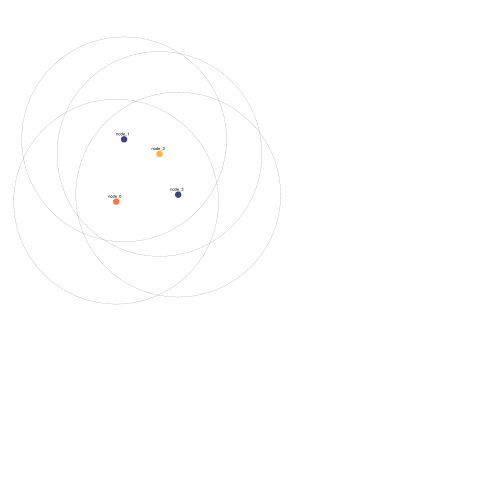

In [5]:
svgio = BytesIO()
side = 500

def draw_df_on(Df,svgio, epoch, folder):
    with cairo.SVGSurface(svgio, side, side) as surface:
        context = cairo.Context(surface)
        context.scale(0.4,0.4)
        context.translate(side/2, side/2)

        context.set_source_rgba(0,0,0,1)
        context.set_dash([1.0])
        context.set_line_width(0.5)
        for row in Df.iterrows():
            Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
            context.arc(X, Y, compute_radius(Name, Df, 16), 0, 2*np.pi)
            context.stroke()

        for row in Df.iterrows():
            Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
            context.set_source_rgba(*palette[Level])
            context.arc(X, Y, 8, 0, 2*np.pi)
            context.fill()

        context.set_source_rgba(0,0,0,1)
        for row in Df.iterrows():
            Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
            context.move_to(X-20,Y-10)
            context.show_text(Name)
            context.stroke()
    with open(folder+"/epoch"+str(epoch)+"_map.svg",'wb') as f:
        f.write(svgio.getvalue())


draw_df_on(Df,svgio, epoch, folder)
IPython.display.SVG(data=svgio.getvalue())
#svgio.close()

In [6]:
def compute_difference(old_Df, Df): 
    difference = 0    
    for row in Df.iterrows():
        Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
        if len(old_Df) != 0 and len(old_Df[old_Df["Name"]==Name]) != 0:
            old_cluster_list = list(old_Df[old_Df["Name"]==Name].cluster_list)[0]
            old_bunch_list = list(old_Df[old_Df["Name"]==Name].bunch_list)[0]
            difference += len(cluster_list) - len(set(cluster_list) & set(old_cluster_list))
            difference += len(bunch_list) - len(set(bunch_list) & set(old_bunch_list))
            #print(old_cluster_list,cluster_list,set(cluster_list) & set(old_cluster_list))
        else:
            difference += len(cluster_list) + len(bunch_list)        
    return difference

In [10]:
folders = ["Random", "Locarno"]
difference_per_folder = []
svgs_per_folder = []
for folder in folders:
    SVGs = []
    Df = []
    old_Df = []
    differences = []
    print(folder, " : ")
    for epoch in epochs:  
        old_Df = Df
        Df = pd.read_csv("../../membershipchainservice/Data/"+folder+"/gentree-node_0-epoch"+str(epoch))
        transform_Df(Df)
        svgio = BytesIO()
        SVGs.append(svgio)
        draw_df_on(Df, svgio, epoch, folder)
        diff = compute_difference(old_Df, Df)
        differences.append(diff)
        print(diff)
    print("\n")
    difference_per_folder.append(differences)
    svgs_per_folder.append(SVGs)

Random  : 
12
22
20
48
56
80
82
112
138


Locarno  : 
14
22
22
36
78
70
106
144
98




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


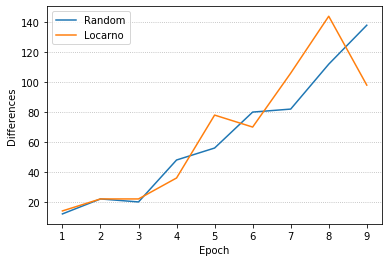

In [11]:
import matplotlib.pyplot as plt

plt.plot(epochs, difference_per_folder[0])
plt.plot(epochs, difference_per_folder[1])
plt.legend(folders)
plt.grid(axis="y", linestyle='dotted')
plt.ylabel("Differences")
plt.xlabel("Epoch")

plt.savefig("differences.eps")
plt.show()

In [9]:
from svgutils.compose import *
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF

for folder in folders:
    nb_per_line = 3

    paths = [folder+"/epoch"+str(epoch)+"_map.svg" for epoch in epochs]
    panels = [Panel(SVG(p), Text(str(i), 25, 20, size=12, weight='bold')).move(side*(i%nb_per_line), side*int(i/nb_per_line)) for i, p in enumerate(paths)]

    Figure(side*nb_per_line, side*(int(len(panels)/nb_per_line)), *panels).save(folder+"/fig_final_compose.svg")
    drawing = svg2rlg(folder+"/fig_final_compose.svg")
    renderPDF.drawToFile(drawing, folder+"/final.pdf")


# DISTANCE MAP

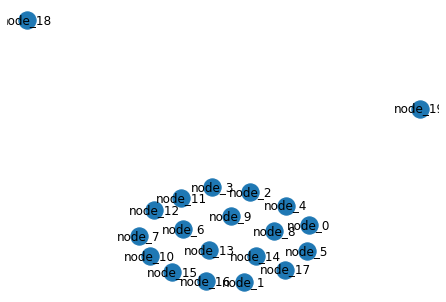

In [93]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.layout import kamada_kawai_layout
np.random.seed(seed=400)

epoch = 9

def CreateDfForDistanceMap(epoch, folder):
    Df = pd.read_csv("../../membershipchainservice/Data/"+folder+"/gentree-node_0-epoch"+str(epoch))
    transform_Df(Df)
    G = nx.Graph()
    G.add_nodes_from(Df["Name"])

    dist_Df = pd.read_csv("../../membershipchainservice/Data/SpaceTime/Distances-node_0-epoch"+str(epoch))

    weight_matrix= {}
    for _, l in dist_Df.iterrows():
        weight_matrix[l[0]] = weight_matrix.get(l[0], {})
        weight_matrix[l[1]] = weight_matrix.get(l[1], {})
        weight_matrix[l[0]][l[1]] = l[2]
        weight_matrix[l[1]][l[0]] = l[2]

    layout = kamada_kawai_layout(
        G,
        scale=200,
        dist=weight_matrix,
        center=[10,0])

    nx.draw(G,layout, with_labels=True)
    plt.show()
    
    Df["Old_X"] = Df["X"]
    Df["Old_Y"] = Df["Y"]
    for name, coord in layout.items():
        X,Y = coord
        Df.loc[Df["Name"]==name, "X"] = X
        Df.loc[Df["Name"]==name, "Y"] = Y
    return Df

_= CreateDfForDistanceMap(9, "Random")

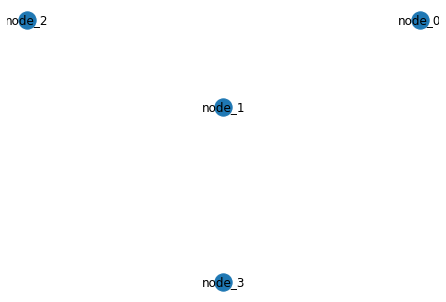

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,2,183.032998,100.076991,"[node_1, node_2, node_3]",[],40.309273,254.230121
1,node_1,0,10.000001,-0.154079,[node_2],"[node_0, node_2]",60.255903,98.322212
2,node_2,0,-163.033016,100.077088,[node_1],"[node_0, node_1, node_3]",148.630526,134.847319
3,node_3,1,10.000016,-200.000000,[node_2],[node_0],195.477892,236.617005


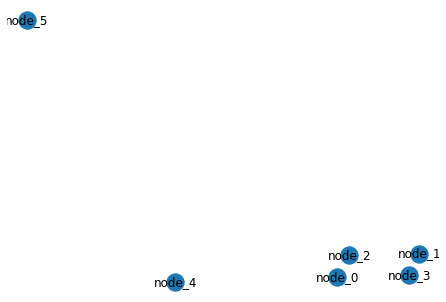

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,24.790321,-48.222702,[],"[node_3, node_4]",40.309273,254.230121
1,node_1,0,48.489921,-25.580654,[node_2],"[node_3, node_4]",60.255903,98.322212
2,node_2,0,28.174614,-26.934908,[node_5],"[node_1, node_3, node_4, node_5]",148.630526,134.847319
3,node_3,2,45.511193,-46.470767,"[node_0, node_1, node_2, node_4, node_5]",[node_4],195.477892,236.617005
4,node_4,2,-22.068787,-52.790969,"[node_0, node_1, node_2, node_3, node_5]",[node_3],31.551759,26.723999
5,node_5,0,-64.897263,200.000000,[node_2],"[node_2, node_3, node_4]",250.729531,129.830120


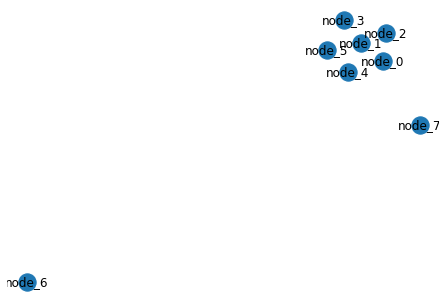

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,49.458832,19.907758,[node_1],"[node_1, node_3, node_4, node_7]",40.309273,254.230121
1,node_1,0,34.730916,34.537756,[node_0],"[node_0, node_3, node_4, node_7]",21.958026,259.850507
2,node_2,0,51.274951,42.540156,[node_5],"[node_3, node_4, node_7]",148.630526,134.847319
3,node_3,2,23.042795,53.005118,"[node_0, node_1, node_2, node_4, node_5, node_...",[node_4],201.123492,27.504937
4,node_4,2,25.750366,11.008416,"[node_0, node_1, node_2, node_3, node_5, node_...",[node_3],49.252960,27.524469
5,node_5,0,11.686943,28.960769,[],"[node_2, node_3, node_4, node_6]",250.729531,129.830120
6,node_6,1,-190.000000,-158.037249,[node_5],"[node_3, node_4]",237.366166,23.275584
7,node_7,1,74.055198,-31.922723,"[node_0, node_1, node_2]","[node_3, node_4]",151.831447,224.027555


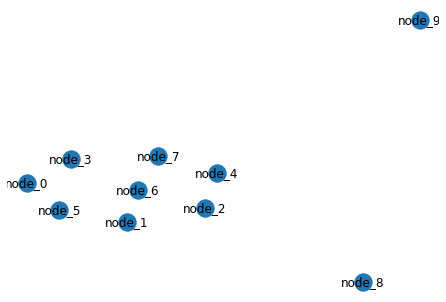

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,-57.443361,-3.479722,[node_1],"[node_1, node_6, node_7, node_8]",40.309273,254.230121
1,node_1,0,-12.924650,-51.604562,[node_0],"[node_0, node_6, node_7, node_8]",21.958026,259.850507
2,node_2,0,21.735240,-34.235452,[],"[node_6, node_7, node_8]",148.630526,134.847319
3,node_3,1,-37.944960,26.422450,[],"[node_6, node_7, node_8, node_9]",294.775088,88.664958
4,node_4,1,27.058006,8.881080,[],"[node_6, node_7, node_8]",54.868695,47.192004
5,node_5,0,-43.064298,-37.127109,[],"[node_6, node_7, node_8]",274.017605,290.943983
6,node_6,2,-8.131161,-12.396991,"[node_0, node_1, node_2, node_3, node_4, node_...","[node_7, node_8]",237.366166,23.275584
7,node_7,2,1.118920,29.997136,"[node_0, node_1, node_2, node_3, node_4, node_...","[node_6, node_8]",151.831447,224.027555
8,node_8,2,92.175171,-126.456831,"[node_0, node_1, node_2, node_3, node_4, node_...","[node_6, node_7]",68.628666,283.581209
9,node_9,1,117.421092,200.000000,[node_3],"[node_6, node_7, node_8]",270.428237,9.176995


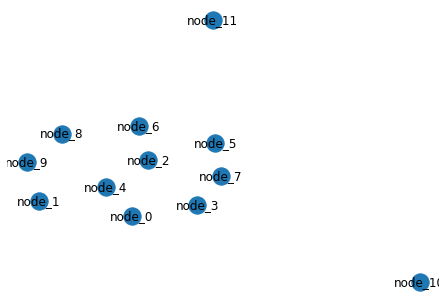

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,-7.614485,-65.713133,"[node_1, node_2]","[node_1, node_2, node_4, node_6, node_7, node_9]",40.309273,254.230121
1,node_1,0,-65.574224,-45.765821,"[node_0, node_2]","[node_0, node_4, node_6, node_7, node_9]",21.958026,259.850507
2,node_2,0,2.918684,10.831381,[node_0],"[node_0, node_1, node_4, node_6, node_7, node_9]",94.820603,270.926485
3,node_3,0,33.370260,-50.908058,[],"[node_4, node_6, node_7, node_9]",73.127790,21.698260
4,node_4,2,-23.894785,-25.995265,"[node_0, node_1, node_10, node_11, node_2, nod...","[node_6, node_7, node_9]",22.538938,190.614628
5,node_5,0,44.758548,33.879938,[],"[node_4, node_6, node_7, node_8, node_9]",274.017605,290.943983
6,node_6,2,-3.038131,55.860039,"[node_0, node_1, node_10, node_11, node_2, nod...","[node_4, node_7, node_9]",237.366166,23.275584
7,node_7,2,48.166908,-11.594336,"[node_0, node_1, node_10, node_11, node_2, nod...","[node_4, node_6, node_9]",284.768385,51.972633
8,node_8,1,-51.314349,46.134349,[node_5],"[node_4, node_6, node_7, node_9]",289.015765,242.475789
9,node_9,2,-73.008945,7.581940,"[node_0, node_1, node_10, node_11, node_2, nod...","[node_4, node_6, node_7]",270.428237,9.176995


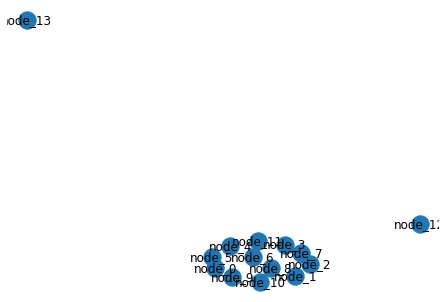

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,-4.612989,-24.374399,[node_4],"[node_10, node_12, node_13, node_4, node_6, no...",40.309273,254.230121
1,node_1,0,24.831476,-31.129454,[node_5],"[node_13, node_5, node_6, node_8, node_9]",195.362681,135.238999
2,node_2,0,30.128321,-20.629648,[node_3],"[node_12, node_13, node_3, node_6, node_8, nod...",121.803590,59.145426
3,node_3,0,21.021178,-2.933326,[node_2],"[node_13, node_2, node_6, node_8, node_9]",78.310049,38.276948
4,node_4,0,0.923483,-4.088718,"[node_0, node_10]","[node_0, node_10, node_12, node_13, node_6, no...",22.538938,190.614628
5,node_5,0,-5.837982,-13.886634,[node_1],"[node_1, node_13, node_6, node_8, node_9]",158.610522,150.269886
6,node_6,2,9.318564,-14.034364,"[node_0, node_1, node_10, node_11, node_12, no...","[node_13, node_8, node_9]",237.366166,23.275584
7,node_7,1,27.099047,-10.892749,[node_11],"[node_13, node_6, node_8, node_9]",284.768385,51.972633
8,node_8,2,15.937873,-24.403331,"[node_0, node_1, node_10, node_11, node_12, no...","[node_13, node_6, node_9]",294.027673,246.828162
9,node_9,2,1.631309,-32.490597,"[node_0, node_1, node_10, node_11, node_12, no...","[node_13, node_6, node_8]",204.490937,215.145979


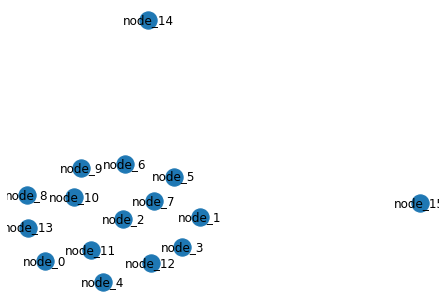

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,-51.310479,-57.073343,"[node_10, node_4]","[node_10, node_12, node_13, node_14, node_4, n...",40.309273,254.230121
1,node_1,0,56.698279,-11.643763,[],"[node_11, node_12, node_13, node_5, node_6, no...",195.362681,135.238999
2,node_2,0,3.244051,-13.897690,"[node_15, node_3]","[node_12, node_13, node_15, node_3, node_6, no...",121.803590,59.145426
3,node_3,0,44.508049,-42.239282,"[node_15, node_2]","[node_12, node_13, node_15, node_2, node_6, no...",78.310049,38.276948
4,node_4,0,-10.863072,-78.055279,"[node_0, node_10]","[node_0, node_10, node_12, node_13, node_14, n...",22.538938,190.614628
5,node_5,0,38.489228,30.069222,[node_1],"[node_12, node_13, node_14, node_6, node_7, no...",158.610522,150.269886
6,node_6,2,4.568887,42.912376,"[node_0, node_1, node_10, node_11, node_12, no...","[node_12, node_13, node_7, node_9]",237.366166,23.275584
7,node_7,2,24.727959,4.953593,"[node_0, node_1, node_10, node_11, node_12, no...","[node_12, node_13, node_6, node_9]",307.428712,56.860665
8,node_8,1,-63.975965,10.681824,[],"[node_12, node_13, node_6, node_7, node_9]",294.027673,246.828162
9,node_9,2,-25.860593,39.105376,"[node_0, node_1, node_10, node_11, node_12, no...","[node_12, node_13, node_6, node_7]",204.490937,215.145979


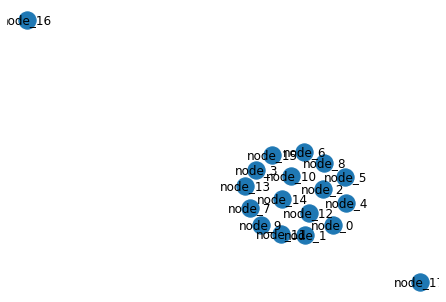

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,44.817841,-32.462198,[node_4],"[node_10, node_14, node_16, node_4, node_7, no...",40.309273,254.230121
1,node_1,0,23.693496,-42.402359,[node_11],"[node_11, node_12, node_14, node_16, node_5, n...",195.362681,135.238999
2,node_2,0,37.245857,0.446777,[node_15],"[node_14, node_15, node_16, node_17, node_7, n...",127.356015,71.108710
3,node_3,0,-13.898626,18.270332,[node_15],"[node_13, node_14, node_16, node_17, node_7, n...",78.310049,38.276948
4,node_4,0,54.951675,-12.594078,[node_0],"[node_0, node_14, node_16, node_7, node_8, nod...",22.538938,190.614628
5,node_5,0,54.234859,11.400162,"[node_1, node_11]","[node_14, node_16, node_7, node_8, node_9]",158.610522,150.269886
6,node_6,1,22.879019,34.340502,[],"[node_14, node_16, node_7, node_8, node_9]",237.366166,23.275584
7,node_7,2,-18.809550,-17.104405,"[node_0, node_1, node_10, node_11, node_12, no...","[node_14, node_16, node_8, node_9]",307.428712,56.860665
8,node_8,2,38.194011,24.366905,"[node_0, node_1, node_10, node_11, node_12, no...","[node_14, node_16, node_7, node_9]",153.084277,223.424300
9,node_9,2,-10.411715,-33.051305,"[node_0, node_1, node_10, node_11, node_12, no...","[node_14, node_16, node_7, node_8]",116.748792,127.760842


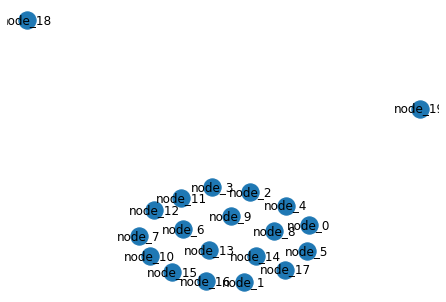

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,55.840784,-6.183004,"[node_15, node_4]","[node_12, node_14, node_15, node_16, node_17, ...",40.309273,254.230121
1,node_1,0,20.416235,-63.238804,[node_10],"[node_10, node_12, node_14, node_17, node_6, n...",211.177078,244.473168
2,node_2,0,23.971347,26.689119,[node_3],"[node_12, node_14, node_17, node_3, node_6, no...",127.356015,71.108710
3,node_3,0,3.168134,32.027367,"[node_18, node_2]","[node_12, node_14, node_17, node_18, node_2, n...",94.105402,55.611305
4,node_4,0,43.252160,13.265935,"[node_0, node_15]","[node_0, node_12, node_14, node_15, node_16, n...",36.391676,192.519245
5,node_5,0,54.842463,-32.349547,[node_11],"[node_12, node_14, node_17, node_6, node_7]",158.610522,150.269886
6,node_6,2,-12.685486,-9.998379,"[node_0, node_1, node_10, node_11, node_12, no...","[node_12, node_14, node_17, node_7]",259.988379,52.127625
7,node_7,2,-36.791860,-17.483354,"[node_0, node_1, node_10, node_11, node_12, no...","[node_12, node_14, node_17, node_6]",307.428712,56.860665
8,node_8,1,37.126416,-12.088519,"[node_0, node_1, node_10]","[node_12, node_14, node_17, node_6, node_7]",153.084277,223.424300
9,node_9,1,13.463475,2.653119,"[node_15, node_16, node_2, node_4]","[node_12, node_14, node_17, node_6, node_7]",116.748792,127.760842


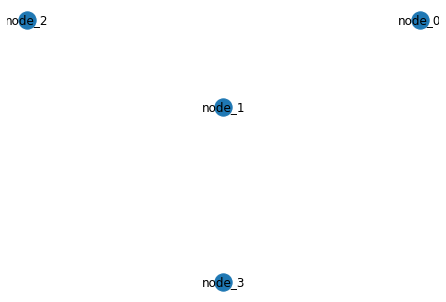

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,1,183.032998,100.076991,"[node_1, node_3]",[node_2],40.309273,254.230121
1,node_1,0,10.000001,-0.154079,[node_3],"[node_0, node_2, node_3]",60.255903,98.322212
2,node_2,2,-163.033016,100.077088,"[node_0, node_1, node_3]",[],148.630526,134.847319
3,node_3,0,10.000016,-200.000000,[node_1],"[node_0, node_1, node_2]",195.477892,236.617005


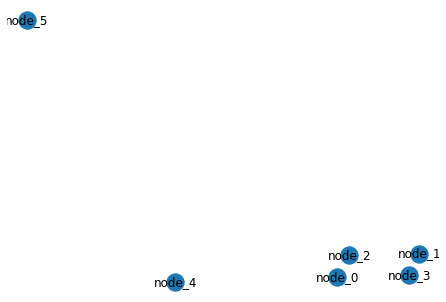

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,24.790321,-48.222702,"[node_1, node_3, node_5]","[node_1, node_2, node_3, node_4]",40.309273,254.230121
1,node_1,0,48.489921,-25.580654,"[node_0, node_3, node_5]","[node_0, node_2, node_3, node_4]",60.255903,98.322212
2,node_2,1,28.174614,-26.934908,"[node_0, node_1, node_3, node_5]",[node_4],148.630526,134.847319
3,node_3,0,45.511193,-46.470767,"[node_0, node_1, node_5]","[node_0, node_1, node_2, node_4]",195.477892,236.617005
4,node_4,2,-22.068787,-52.790969,"[node_0, node_1, node_2, node_3, node_5]",[],31.551759,26.723999
5,node_5,0,-64.897263,200.000000,[],"[node_0, node_1, node_2, node_3, node_4]",250.729531,129.830120


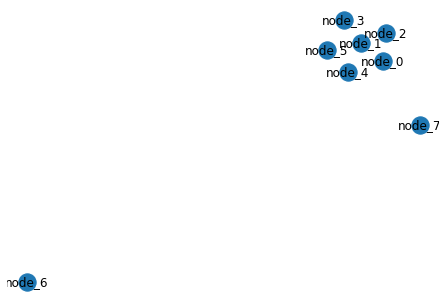

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,49.458832,19.907758,"[node_1, node_3, node_5, node_7]","[node_1, node_2, node_3, node_4, node_5]",40.309273,254.230121
1,node_1,0,34.730916,34.537756,"[node_0, node_3, node_5, node_7]","[node_0, node_2, node_3, node_4, node_5]",21.958026,259.850507
2,node_2,1,51.274951,42.540156,"[node_0, node_1, node_3, node_5, node_6, node_7]",[node_4],148.630526,134.847319
3,node_3,0,23.042795,53.005118,"[node_0, node_1, node_5, node_7]","[node_0, node_1, node_2, node_4, node_5]",201.123492,27.504937
4,node_4,2,25.750366,11.008416,"[node_0, node_1, node_2, node_3, node_5, node_...",[],49.252960,27.524469
5,node_5,0,11.686943,28.960769,"[node_0, node_1, node_3, node_7]","[node_0, node_1, node_2, node_3, node_4]",250.729531,129.830120
6,node_6,1,-190.000000,-158.037249,[],"[node_2, node_4]",237.366166,23.275584
7,node_7,0,74.055198,-31.922723,[],"[node_0, node_1, node_2, node_3, node_4, node_5]",151.831447,224.027555


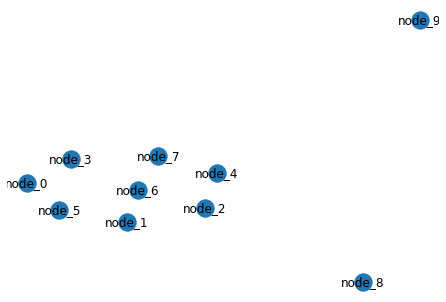

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,-57.443361,-3.479722,"[node_1, node_3, node_5, node_6, node_7]","[node_1, node_2, node_3, node_4, node_5, node_...",40.309273,254.230121
1,node_1,0,-12.924650,-51.604562,"[node_0, node_3, node_5, node_6, node_7]","[node_0, node_2, node_3, node_4, node_5, node_...",21.958026,259.850507
2,node_2,1,21.735240,-34.235452,"[node_0, node_1, node_3, node_5, node_6, node_...",[node_4],148.630526,134.847319
3,node_3,0,-37.944960,26.422450,"[node_0, node_1, node_5, node_6, node_7]","[node_0, node_1, node_2, node_4, node_5, node_...",294.775088,88.664958
4,node_4,2,27.058006,8.881080,"[node_0, node_1, node_2, node_3, node_5, node_...",[],54.868695,47.192004
5,node_5,0,-43.064298,-37.127109,"[node_0, node_1, node_3, node_6, node_7]","[node_0, node_1, node_2, node_3, node_4, node_...",274.017605,290.943983
6,node_6,0,-8.131161,-12.396991,"[node_0, node_1, node_3, node_5, node_7]","[node_0, node_1, node_2, node_3, node_4, node_...",237.366166,23.275584
7,node_7,0,1.118920,29.997136,"[node_0, node_1, node_3, node_5, node_6]","[node_0, node_1, node_2, node_3, node_4, node_...",151.831447,224.027555
8,node_8,0,92.175171,-126.456831,[],"[node_2, node_4]",68.628666,283.581209
9,node_9,1,117.421092,200.000000,[],"[node_2, node_4]",270.428237,9.176995


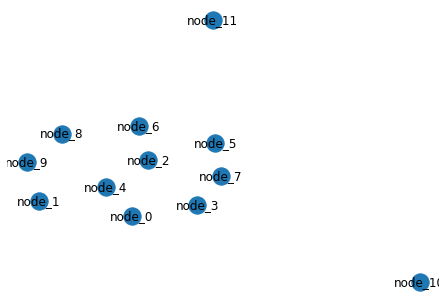

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,-7.614485,-65.713133,"[node_1, node_11, node_2, node_3, node_5, node...","[node_1, node_2, node_3, node_4, node_5, node_...",40.309273,254.230121
1,node_1,0,-65.574224,-45.765821,"[node_0, node_11, node_2, node_3, node_5, node...","[node_0, node_2, node_3, node_4, node_5, node_...",21.958026,259.850507
2,node_2,0,2.918684,10.831381,"[node_0, node_1, node_11, node_3, node_5, node...","[node_0, node_1, node_3, node_4, node_5, node_...",94.820603,270.926485
3,node_3,0,33.370260,-50.908058,"[node_0, node_1, node_11, node_2, node_5, node...","[node_0, node_1, node_2, node_4, node_5, node_...",73.127790,21.698260
4,node_4,2,-23.894785,-25.995265,"[node_0, node_1, node_10, node_11, node_2, nod...",[],22.538938,190.614628
5,node_5,0,44.758548,33.879938,"[node_0, node_1, node_11, node_2, node_3, node...","[node_0, node_1, node_2, node_3, node_4, node_...",274.017605,290.943983
6,node_6,0,-3.038131,55.860039,"[node_0, node_1, node_11, node_2, node_3, node...","[node_0, node_1, node_2, node_3, node_4, node_...",237.366166,23.275584
7,node_7,0,48.166908,-11.594336,"[node_0, node_1, node_11, node_2, node_3, node...","[node_0, node_1, node_2, node_3, node_4, node_...",284.768385,51.972633
8,node_8,0,-51.314349,46.134349,"[node_0, node_1, node_11, node_2, node_3, node...","[node_0, node_1, node_2, node_3, node_4, node_...",289.015765,242.475789
9,node_9,1,-73.008945,7.581940,"[node_0, node_1, node_10, node_11, node_2, nod...",[node_4],270.428237,9.176995


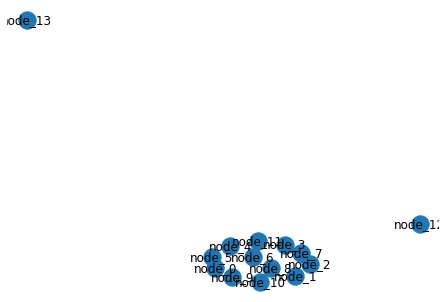

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,-4.612989,-24.374399,"[node_1, node_11, node_13, node_3, node_5, nod...","[node_1, node_10, node_11, node_2, node_3, nod...",40.309273,254.230121
1,node_1,0,24.831476,-31.129454,"[node_0, node_11, node_13, node_3, node_5, nod...","[node_0, node_10, node_11, node_2, node_3, nod...",195.362681,135.238999
2,node_2,1,30.128321,-20.629648,"[node_0, node_1, node_10, node_11, node_12, no...","[node_10, node_4, node_9]",121.803590,59.145426
3,node_3,0,21.021178,-2.933326,"[node_0, node_1, node_11, node_13, node_5, nod...","[node_0, node_1, node_10, node_11, node_2, nod...",78.310049,38.276948
4,node_4,2,0.923483,-4.088718,"[node_0, node_1, node_10, node_11, node_12, no...",[],22.538938,190.614628
5,node_5,0,-5.837982,-13.886634,"[node_0, node_1, node_11, node_13, node_3, nod...","[node_0, node_1, node_10, node_11, node_2, nod...",158.610522,150.269886
6,node_6,0,9.318564,-14.034364,"[node_0, node_1, node_11, node_13, node_3, nod...","[node_0, node_1, node_10, node_11, node_2, nod...",237.366166,23.275584
7,node_7,0,27.099047,-10.892749,"[node_0, node_1, node_11, node_13, node_3, nod...","[node_0, node_1, node_10, node_11, node_2, nod...",284.768385,51.972633
8,node_8,0,15.937873,-24.403331,"[node_0, node_1, node_11, node_13, node_3, nod...","[node_0, node_1, node_10, node_11, node_2, nod...",294.027673,246.828162
9,node_9,1,1.631309,-32.490597,"[node_0, node_1, node_10, node_11, node_12, no...","[node_10, node_2, node_4]",204.490937,215.145979


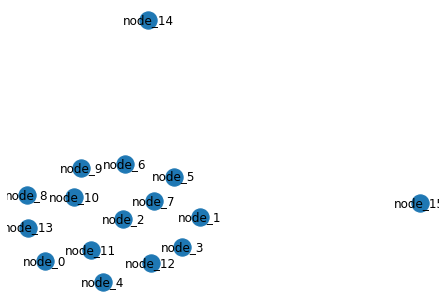

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,-51.310479,-57.073343,"[node_1, node_11, node_12, node_13, node_14, n...","[node_1, node_10, node_11, node_12, node_13, n...",40.309273,254.230121
1,node_1,0,56.698279,-11.643763,"[node_0, node_11, node_12, node_13, node_14, n...","[node_0, node_10, node_11, node_12, node_13, n...",195.362681,135.238999
2,node_2,0,3.244051,-13.897690,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",121.803590,59.145426
3,node_3,0,44.508049,-42.239282,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",78.310049,38.276948
4,node_4,2,-10.863072,-78.055279,"[node_0, node_1, node_10, node_11, node_12, no...",[],22.538938,190.614628
5,node_5,0,38.489228,30.069222,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",158.610522,150.269886
6,node_6,0,4.568887,42.912376,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",237.366166,23.275584
7,node_7,0,24.727959,4.953593,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",307.428712,56.860665
8,node_8,0,-63.975965,10.681824,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",294.027673,246.828162
9,node_9,1,-25.860593,39.105376,"[node_0, node_1, node_10, node_11, node_12, no...","[node_10, node_4]",204.490937,215.145979


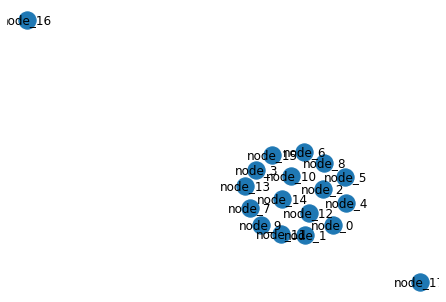

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,44.817841,-32.462198,"[node_1, node_11, node_12, node_13, node_14, n...","[node_1, node_10, node_11, node_12, node_13, n...",40.309273,254.230121
1,node_1,0,23.693496,-42.402359,"[node_0, node_11, node_12, node_13, node_14, n...","[node_0, node_10, node_11, node_12, node_13, n...",195.362681,135.238999
2,node_2,0,37.245857,0.446777,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",127.356015,71.108710
3,node_3,0,-13.898626,18.270332,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",78.310049,38.276948
4,node_4,1,54.951675,-12.594078,"[node_0, node_1, node_10, node_11, node_12, no...","[node_10, node_15, node_16]",22.538938,190.614628
5,node_5,0,54.234859,11.400162,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",158.610522,150.269886
6,node_6,0,22.879019,34.340502,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",237.366166,23.275584
7,node_7,0,-18.809550,-17.104405,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",307.428712,56.860665
8,node_8,0,38.194011,24.366905,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",153.084277,223.424300
9,node_9,0,-10.411715,-33.051305,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",116.748792,127.760842


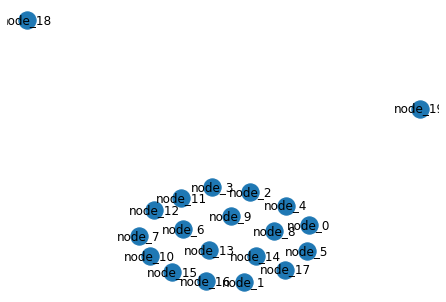

,Name,Level,X,Y,cluster_list,bunch_list,Old_X,Old_Y
0,node_0,0,55.840784,-6.183004,"[node_1, node_11, node_12, node_13, node_14, n...","[node_1, node_10, node_11, node_12, node_13, n...",40.309273,254.230121
1,node_1,0,20.416235,-63.238804,"[node_0, node_11, node_12, node_13, node_14, n...","[node_0, node_10, node_11, node_12, node_13, n...",211.177078,244.473168
2,node_2,0,23.971347,26.689119,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",127.356015,71.108710
3,node_3,0,3.168134,32.027367,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",94.105402,55.611305
4,node_4,1,43.252160,13.265935,"[node_0, node_1, node_10, node_11, node_12, no...","[node_10, node_15, node_16]",36.391676,192.519245
5,node_5,0,54.842463,-32.349547,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",158.610522,150.269886
6,node_6,0,-12.685486,-9.998379,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",259.988379,52.127625
7,node_7,0,-36.791860,-17.483354,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",307.428712,56.860665
8,node_8,0,37.126416,-12.088519,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",153.084277,223.424300
9,node_9,0,13.463475,2.653119,"[node_0, node_1, node_11, node_12, node_13, no...","[node_0, node_1, node_10, node_11, node_12, no...",116.748792,127.760842


In [116]:
DFs = []
for folder in folders:
    epoch_df = []
    SVGs = []
    save_folder ="SpaceTime/"+folder
    for epoch in epochs: 
        Df = CreateDfForDistanceMap(epoch, folder)
        epoch_df.append(Df.drop(["cluster", "bunch"], axis=1))
        display(Df.drop(["cluster", "bunch"], axis=1))
        
        svgio = BytesIO()
        SVGs.append(svgio)
        draw_df_on(Df.drop(["Old_X", "Old_Y"], axis=1), svgio, epoch, save_folder)
    DFs.append(epoch_df)
        
    paths = [save_folder+"/epoch"+str(epoch)+"_map.svg" for epoch in epochs]
    panels = [Panel(SVG(p), Text(str(i), 25, 20, size=12, weight='bold')).move(side*(i%nb_per_line), side*int(i/nb_per_line)) for i, p in enumerate(paths)]

    Figure(side*nb_per_line, side*(int(len(panels)/nb_per_line)), *panels).save(save_folder+"/fig_final_compose.svg")
    drawing = svg2rlg(save_folder+"/fig_final_compose.svg")
    renderPDF.drawToFile(drawing, save_folder+"/final.pdf")

In [152]:
for epoch in epochs[:-1]: 
    string  = r"""\begin{table}[h]
\centering
\tiny
\begin{tabular}{@{}llrrrrrrll@{}}
\toprule
& \textbf{Name}   &\textbf{Random Level} &\textbf{Locarno Level} & \textbf{X} & \textbf{Y} & \textbf{SpaceTime X} & \textbf{SpaceTime Y}  \\ \midrule"""
    
    df1,df2 = DFs[0][epoch],DFs[1][epoch]
    for num, l in df1.iterrows():
        Name, Random_Level, X, Y, cluster_list, bunch_list, Old_X, Old_Y= l
        Locarno_Level = list(df2.loc[df2["Name"]==Name,"Level"])[0]
        Name = Name.replace("_", " ").replace("n", "N") 
        string += "\n"
        string += r"\textbf{"+str(num)+"} & "+ ("{}&"+2*"${}$&"+4*"${:.2f}$&").format(Name, Random_Level, Locarno_Level, Old_X,Old_Y,X,Y) +r"\\ \hdashline"
    
    string+= r"""\midrule
\bottomrule
\end{tabular}
\caption{Description of the system for Epoch """ + str(epoch) + """}
\end{table}"""
    print(string)
    print("\n")
    


\begin{table}[h]
\centering
\tiny
\begin{tabular}{@{}llrrrrrrll@{}}
\toprule
& \textbf{Name}   &\textbf{Random Level} &\textbf{Locarno Level} & \textbf{X} & \textbf{Y} & \textbf{SpaceTime X} & \textbf{SpaceTime Y}  \\ \midrule
\textbf{0} & Node 0&$0$&$0$&$40.31$&$254.23$&$24.79$&$-48.22$&\\ \hdashline
\textbf{1} & Node 1&$0$&$0$&$60.26$&$98.32$&$48.49$&$-25.58$&\\ \hdashline
\textbf{2} & Node 2&$0$&$1$&$148.63$&$134.85$&$28.17$&$-26.93$&\\ \hdashline
\textbf{3} & Node 3&$2$&$0$&$195.48$&$236.62$&$45.51$&$-46.47$&\\ \hdashline
\textbf{4} & Node 4&$2$&$2$&$31.55$&$26.72$&$-22.07$&$-52.79$&\\ \hdashline
\textbf{5} & Node 5&$0$&$0$&$250.73$&$129.83$&$-64.90$&$200.00$&\\ \hdashline\midrule
\bottomrule
\end{tabular}
\caption{Description of the system for Epoch 1}
\end{table}


\begin{table}[h]
\centering
\tiny
\begin{tabular}{@{}llrrrrrrll@{}}
\toprule
& \textbf{Name}   &\textbf{Random Level} &\textbf{Locarno Level} & \textbf{X} & \textbf{Y} & \textbf{SpaceTime X} & \textbf{SpaceTime Y}  \\ 

# Multiples Runs

In [12]:
import pandas as pd
difference_per_folder_average = []
difference_per_folder_max = []
difference_per_folder_min = []
epochs = [i for i in range(1,10)]

folders = ["Random", "Locarno"]
difference_total = []
diff_Locarno = []
diff_Random = []
for exp in range(1,101):
    difference_per_folder = []
    for i, folder in enumerate(folders):
        Df = []
        old_Df = []
        differences = []
        for epoch in epochs:  
            old_Df = Df
            Df = pd.read_csv("../../membershipchainservice/Data/"+str(exp)+"/"+folder+"/gentree-node_0-epoch"+str(epoch))
            transform_Df(Df)
            diff = compute_difference(old_Df, Df)
            differences.append(diff)
        difference_per_folder.append(differences)
        if i == 0: 
            diff_Random.append(differences)
        else:
            diff_Locarno.append(differences)
    difference_total.append(difference_per_folder)
    
# struct : diff_tot > exp1 
#                   > exp2 > Random
#                          > Locarno > [2,5,3,4,5,6,3,3,2,]

    

In [14]:
Rdata_mean = np.array([np.mean([l[i] for l in diff_Random]) for i, d in enumerate(diff_Random[0])])
Rdata_max = np.array([np.max([l[i] for l in diff_Random]) for i, d in enumerate(diff_Random[0])])
Rdata_min = np.array([np.min([l[i] for l in diff_Random]) for i, d in enumerate(diff_Random[0])])
Rdata_std = np.array([np.std([l[i] for l in diff_Random]) for i, d in enumerate(diff_Random[0])])
Rdata_quantile = np.quantile(diff_Random, [0.5,0.9, 0.1], axis = 0)

Ldata_mean = np.array([np.mean([l[i] for l in diff_Locarno]) for i, d in enumerate(diff_Locarno[0])])
Ldata_max = np.array([np.max([l[i] for l in diff_Locarno]) for i, d in enumerate(diff_Locarno[0])])
Ldata_min = np.array([np.min([l[i] for l in diff_Locarno]) for i, d in enumerate(diff_Locarno[0])])
Ldata_std = np.array([np.std([l[i] for l in diff_Locarno]) for i, d in enumerate(diff_Locarno[0])])
Ldata_quantile = np.quantile(diff_Locarno, [0.5,0.9, 0.1], axis = 0)

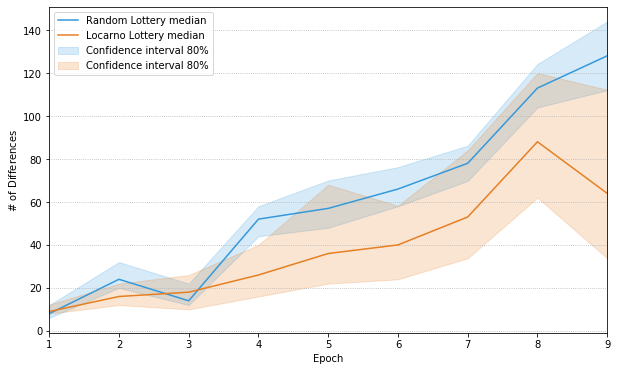

In [139]:
import matplotlib.pyplot as plt
colors = [(52/255.0, 152/255.0, 219/255.0,1.0),
          (230/255.0, 126/255.0, 34/255.0,1.0)]
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
#plt.plot(epochs, Rdata_mean, color=colors[0])
#plt.plot(epochs, Ldata_mean, color=colors[1])
#plt.fill_between(epochs, Rdata_mean+Rdata_std, Rdata_mean-Rdata_std, color=colors[0], alpha=0.4)
#plt.fill_between(epochs, Ldata_mean+Ldata_std, Ldata_mean-Ldata_std, color=colors[1], alpha=0.4)
#plt.fill_between(epochs, Rdata_max, Rdata_min, color=colors[0], alpha=0.1)
#plt.fill_between(epochs, Ldata_max, Ldata_min, color=colors[1], alpha=0.1)

plt.plot(epochs, Rdata_quantile[0], color=colors[0])
plt.fill_between(epochs, Rdata_quantile[1], Rdata_quantile[2], color=colors[0], alpha=0.2)

plt.plot(epochs, Ldata_quantile[0], color=colors[1])
plt.fill_between(epochs, Ldata_quantile[1], Ldata_quantile[2], color=colors[1], alpha=0.2)


#plt.legend(["Random Lottery", "Locarno Lottery", "Random Std Dev","Locarno Std Dev", "Locarno Min-Max", "Random Min-Max"])
plt.legend(["Random Lottery median", "Locarno Lottery median", "Confidence interval 80%","Confidence interval 80%", "Locarno Min-Max", "Random Min-Max"])
plt.grid(axis="y", linestyle='dotted')
plt.ylabel("$\#$ of Differences")
plt.xlabel("Epoch")
plt.xlim([1,9])

plt.savefig("../../latex/thesis_template/figures/LocarnoTreaties-differences.pdf")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

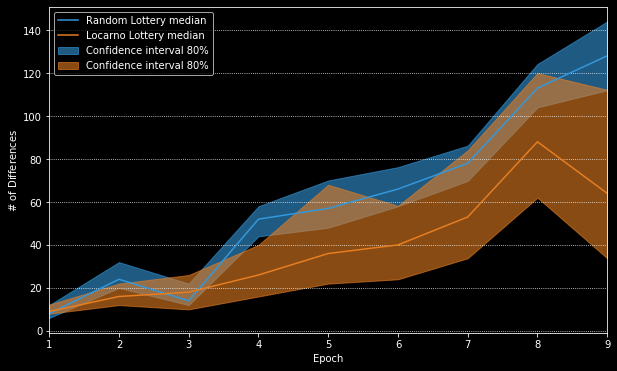

In [15]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

colors = [(52/255.0, 152/255.0, 219/255.0,1.0),
          (230/255.0, 126/255.0, 34/255.0,1.0)]
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))


plt.plot(epochs, Rdata_quantile[0], color=colors[0])
plt.fill_between(epochs, Rdata_quantile[1], Rdata_quantile[2], color=colors[0], alpha=0.6)

plt.plot(epochs, Ldata_quantile[0], color=colors[1])
plt.fill_between(epochs, Ldata_quantile[1], Ldata_quantile[2], color=colors[1], alpha=0.6)


#plt.legend(["Random Lottery", "Locarno Lottery", "Random Std Dev","Locarno Std Dev", "Locarno Min-Max", "Random Min-Max"])
plt.legend(["Random Lottery median", "Locarno Lottery median", "Confidence interval 80%","Confidence interval 80%", "Locarno Min-Max", "Random Min-Max"])
plt.grid(axis="y", linestyle='dotted')
plt.ylabel("$\#$ of Differences")
plt.xlabel("Epoch")
plt.xlim([1,9])

plt.savefig("../../latex/thesis_template/figures/LocarnoTreaties-differences.eps")
plt.show()